In [2]:
import streamlit as st

import numpy as np
import pandas as pd
from scipy import stats
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime,timedelta
mpl.rcParams['figure.figsize'] = (18,12)

import psycopg2
import sys

import math

import plotly.express as px
import plotly.graph_objects as go

import holidays

sns.set()
sns.set_style('whitegrid')

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import STL
from sklearn import linear_model as lm

from sklearn.preprocessing import MinMaxScaler

import pmdarima as pm

In [4]:
param_dic = {
    "host"      : "localhost",
    "database"  : "demand",
    "user"      : "postgres",
    "password"  : "password"
}

def connect(params_dic):
    """ Connect to the PostgreSQL database server """
    conn = None
    try:
        # connect to the PostgreSQL server
        print('Connecting to the PostgreSQL database...')
        conn = psycopg2.connect(**params_dic)
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        sys.exit(1) 
    print("Connection successful")
    return conn

def postgresql_to_dataframe(conn, select_query, column_names):
    """
    Tranform a SELECT query into a pandas dataframe
    """
    cursor = conn.cursor()
    try:
        cursor.execute(select_query)
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        cursor.close()
        return 1
    
    tupples = cursor.fetchall()
    cursor.close()
    
    data = pd.DataFrame(tupples, columns=column_names)
    return data

In [5]:
def deal_with_holidays(data,end_year,start_year='2018'):
    holiday = holidays.Canada()
    hol_list = holiday[start_year:str(end_year)]
    for date in hol_list:
        data.loc[datetime.strftime(date,'%Y-%m-%d'),'holiday_idx'] = 1
        
def deal_with_dayofweek(x):
    if x == 'Weekday':
        return 1
    else:
        return 0
    
def deal_with_temperature(x):
    if x == 'Hot':
        return 1
    else:
        return 0

In [6]:
conn = connect(param_dic)

column_names = ['timestamp', 'hour', 'temp_index', 'week_index', 'temperature', 'demand']

query = ("SELECT temp_data.timestamp,hour,temp_index,week_index,temperature,demand_data.demand" 
         " FROM temp_data LEFT JOIN demand_data ON temp_data.timestamp = demand_data.timestamp"
         " ORDER BY timestamp")


data = postgresql_to_dataframe(conn, query, column_names)
data.set_index('timestamp',inplace=True)

Connecting to the PostgreSQL database...
Connection successful


In [7]:
data.dropna(inplace=True)

2021-02-23 16:17:18.311 INFO    numexpr.utils: NumExpr defaulting to 8 threads.


In [9]:
display(data.head())
display(data.shape)

,hour,temp_index,week_index,temperature,demand
timestamp,,,,,
2018-01-01 00:00:00,0,NotHot,Weekday,-19.5,5340.0
2018-01-01 01:00:00,1,NotHot,Weekday,-21.7,5211.0
2018-01-01 02:00:00,2,NotHot,Weekday,-19.3,5096.0
2018-01-01 03:00:00,3,NotHot,Weekday,-20.3,4987.0
2018-01-01 04:00:00,4,NotHot,Weekday,-19.9,4926.0


(27501, 5)

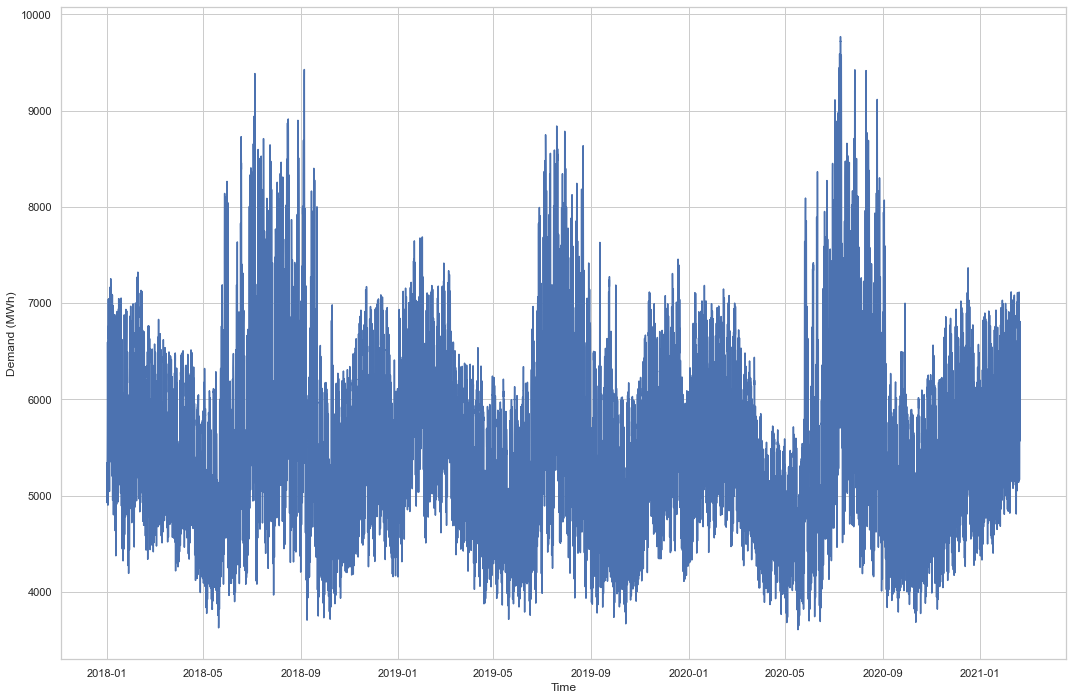

In [79]:
sns.lineplot(x='timestamp',y='demand',data=data.reset_index());
plt.xlabel('Time');
plt.ylabel('Demand (MWh)');

In [8]:
data['holiday_idx'] = 0
end_year = data.reset_index().iloc[-1]['timestamp'].year
data['week_index'] = data['week_index'].map(deal_with_dayofweek)
data['temp_index'] = data['temp_index'].map(deal_with_temperature)
deal_with_holidays(data,end_year)
data.drop(['hour'],axis=1,inplace=True)

In [9]:
display(data.head())
display(data.shape)

,temp_index,week_index,temperature,demand,holiday_idx
timestamp,,,,,
2018-01-01 00:00:00,0,1,-19.5,5340.0,0
2018-01-01 01:00:00,0,1,-21.7,5211.0,0
2018-01-01 02:00:00,0,1,-19.3,5096.0,0
2018-01-01 03:00:00,0,1,-20.3,4987.0,0
2018-01-01 04:00:00,0,1,-19.9,4926.0,0


(27501, 5)

In [10]:
data_1 = data.copy()
data.drop(['holiday_idx','temperature','week_index','temp_index'],axis=1,inplace=True)

In [11]:
display(data.head())
display(data.shape)

,demand
timestamp,
2018-01-01 00:00:00,5340.0
2018-01-01 01:00:00,5211.0
2018-01-01 02:00:00,5096.0
2018-01-01 03:00:00,4987.0
2018-01-01 04:00:00,4926.0


(27501, 1)

In [12]:
def fourier_terms_year(df,ky):
    
    """
    Takes in a dataframe and returns the dataframe with 2*ky fourier terms
    """
    
    data = df.copy()
    
    for y in range(1,ky+1):
        data['sin_year'+str(y)] = np.sin(2*y*np.pi*data.index.dayofyear/365.24) 
        data['cos_year'+str(y)] = np.cos(2*y*np.pi*data.index.dayofyear/365.24)

    return data

def fourier_terms_year_week(df,ky,kw):
    
    """
    Takes in a dataframe and returns the dataframe with 2*(ky+kw) fourier terms
    """
    
    data = df.copy()
    
    for y in range(1,ky+1):
        data['sin_year'+str(y)] = np.sin(2*y*np.pi*data.index.dayofyear/365.24) 
        data['cos_year'+str(y)] = np.cos(2*y*np.pi*data.index.dayofyear/365.24)

    for w in range(1,kw+1):
        data['sin_week'+str(w)] = np.sin(2*w*np.pi*data.index.dayofweek/7)
        data['cos_week'+str(w)] = np.cos(2*w*np.pi*data.index.dayofweek/7)

    return data

def fourier_terms_year_week_day(df,ky,kw,kd):
    
    """
    Takes in a dataframe and returns the dataframe with 2*(ky+kw+kd) fourier terms
    """
    
    data = df.copy()
    
    for y in range(1,ky+1):
        data['sin_year'+str(y)] = np.sin(2*y*np.pi*data.index.dayofyear/365.24) 
        data['cos_year'+str(y)] = np.cos(2*y*np.pi*data.index.dayofyear/365.24)

    for w in range(1,kw+1):
        data['sin_week'+str(w)] = np.sin(2*w*np.pi*data.index.dayofweek/7)
        data['cos_week'+str(w)] = np.cos(2*w*np.pi*data.index.dayofweek/7)

    for d in range(1,kd+1):
        data['sin_hour'+str(d)] = np.sin(2*d*np.pi*data.index.hour/24)
        data['cos_hour'+str(d)] = np.cos(2*d*np.pi*data.index.hour/24) 

    return data


def fourier_terms_year_day(df,ky,kd):
    
    """
    Takes in a dataframe and returns the dataframe with 2*(ky+kd) fourier terms
    """
    
    data = df.copy()
    
    for y in range(1,ky+1):
        data['sin_year'+str(y)] = np.sin(2*y*np.pi*data.index.dayofyear/365.24) 
        data['cos_year'+str(y)] = np.cos(2*y*np.pi*data.index.dayofyear/365.24)

    for d in range(1,kd+1):
        data['sin_hour'+str(d)] = np.sin(2*d*np.pi*data.index.hour/24)
        data['cos_hour'+str(d)] = np.cos(2*d*np.pi*data.index.hour/24) 

    return data


def my_data(data,pred_start):
    
    """
    Takes in a dataframe and a start date for predictions and performs a train test split
    """
    
    train_end = (datetime.strptime(pred_start,'%Y-%m-%d') - timedelta(days=1)).strftime('%Y-%m-%d')
    
    pred_day = data.loc[pred_start:]
    train_days = data.loc[:train_end]
    
    y_train = train_days['demand'].to_numpy().reshape(-1, 1)
    X_train = train_days.loc[:, train_days.columns != 'demand']
    y_test = pred_day['demand'].to_numpy().reshape(-1, 1)
    X_test = pred_day.loc[:, pred_day.columns != 'demand']
    
    return X_train, X_test, y_train, y_test

The value of K: (75)


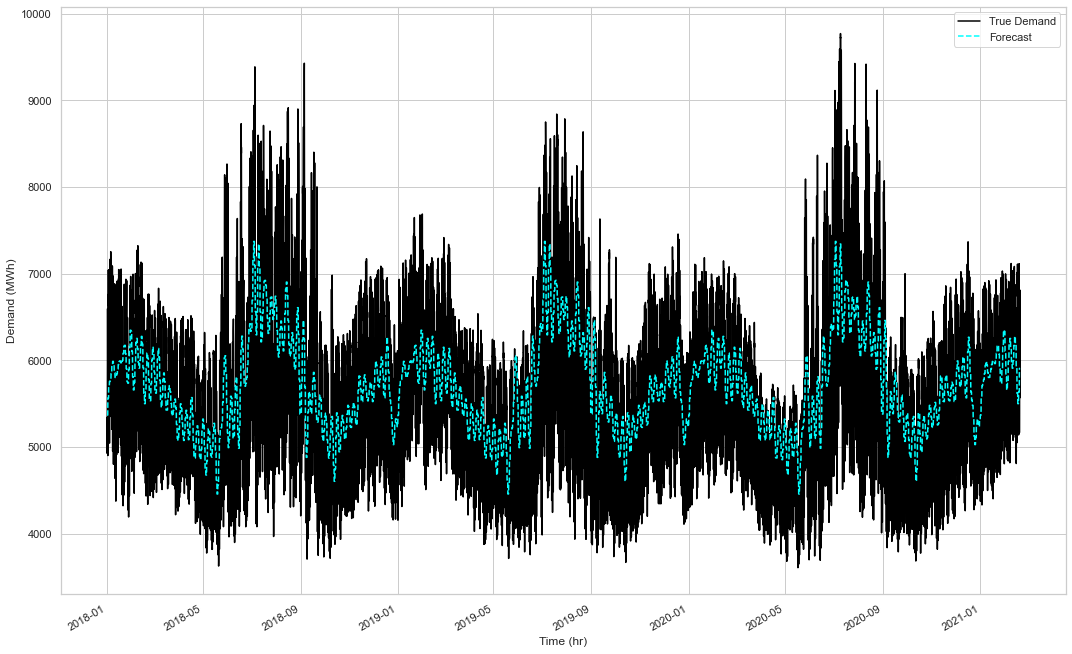

In [13]:
myterms = [5,10,15,25,60,75,80,90]
aic = []

for K in myterms:
    
    df = fourier_terms_year(data,K)
    
    demand = df.pop('demand')
    df['demand'] = demand
    X_train, X_test, y_train, y_test = my_data(df,'2021-01-20')
    
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)

    model = sm.OLS(y_train,X_train).fit()
    
    aic.append(model.aic)
    
K_1 = myterms[np.argmin(aic)]

df_1 = fourier_terms_year(data,K_1)

df_1['demand'] = df_1.pop('demand')
X_train_1, X_test_1, y_train_1, y_test_1 = my_data(df_1,'2021-01-20')

X_train_1 = sm.add_constant(X_train_1)
X_test_1 = sm.add_constant(X_test_1)

model_1 = sm.OLS(y_train_1,X_train_1).fit()
    
predictions_1 = model_1.predict(X_test_1)

print(f'The value of K: ({K_1})')

plt.plot(data.reset_index()['timestamp'], data['demand'], label='True Demand',color="black");
plt.plot(model_1.predict(sm.add_constant(df_1.loc[:, df_1.columns != 'demand'])),label='Forecast',color='aqua',linestyle='dashed')    
plt.gcf().autofmt_xdate();
plt.legend();
plt.xlabel('Time (hr)');
plt.ylabel('Demand (MWh)');

The value of K: ((75, 5))


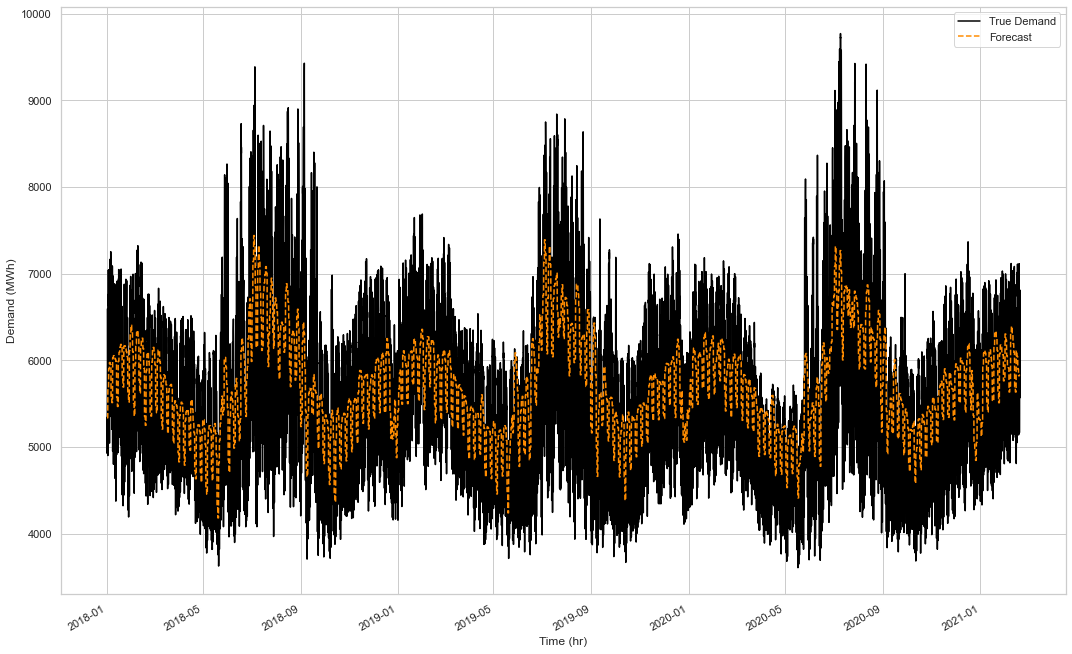

In [14]:
myterms_1 = [5,10,15,25,60,75,80,90]
myterms_2 = [2,5,7]

aic = np.zeros((len(myterms_1),len(myterms_2)))

for i,K1 in enumerate(myterms_1):
    for j,K2 in enumerate(myterms_2):
    
        df = fourier_terms_year_week(data,K1,K2)

        demand = df.pop('demand')
        df['demand'] = demand
        X_train, X_test, y_train, y_test = my_data(df,'2021-01-20')

        X_train = sm.add_constant(X_train)
        X_test = sm.add_constant(X_test)

        model = sm.OLS(y_train,X_train).fit()
    
        aic[i][j] = model.aic
        
K1_2 = myterms_1[math.floor(aic.argmin()/len(myterms_2))]
K2_2 = myterms_2[aic.argmin() - (math.floor(aic.argmin()/3))*len(myterms_2)]

df_2 = fourier_terms_year_week(data,K1_2,K2_2)

df_2['demand'] = df_2.pop('demand')

X_train_2, X_test_2, y_train_2, y_test_2 = my_data(df_2,'2021-01-20')

X_train_2 = sm.add_constant(X_train_2)
X_test_2 = sm.add_constant(X_test_2)

model_2 = sm.OLS(y_train_2,X_train_2).fit()
predictions_2 = model_2.predict(X_test_2)

print(f'The value of K: ({K1_2,K2_2})')

plt.plot(data.reset_index()['timestamp'], data['demand'], label='True Demand',color="black");
plt.plot(model_2.predict(sm.add_constant(df_2.loc[:, df_2.columns != 'demand'])),label='Forecast',color='darkorange',linestyle='dashed') 
plt.gcf().autofmt_xdate();
plt.legend();
plt.xlabel('Time (hr)');
plt.ylabel('Demand (MWh)');

The value of K: ((90, 5, 5))


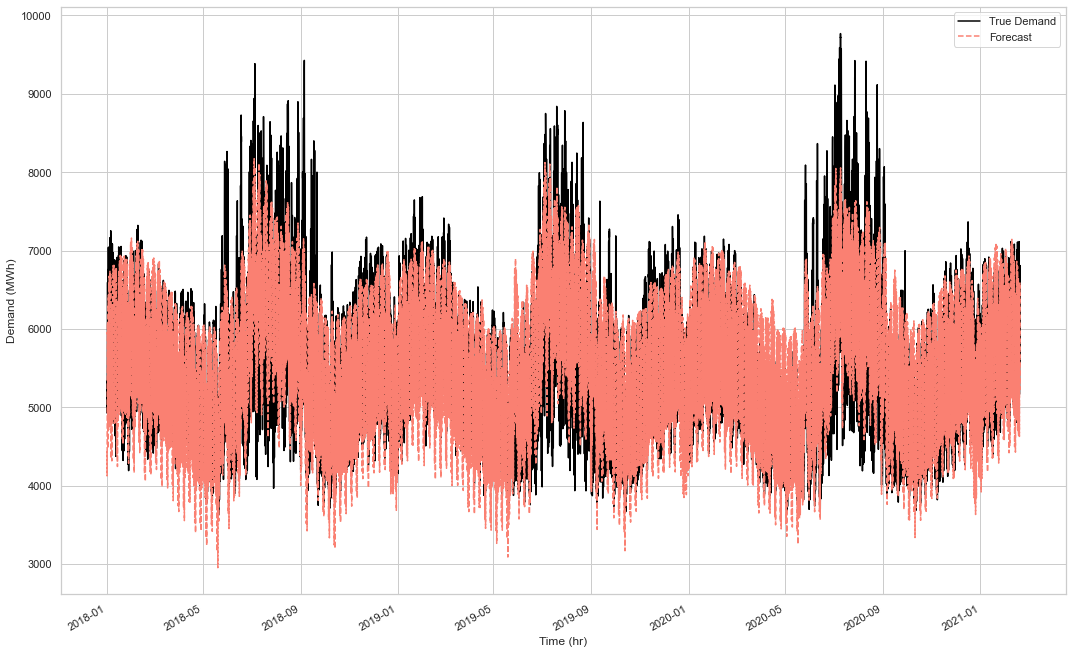

In [15]:
myterms_1 = [5,25,50,75,80,90]
myterms_2 = [2,5,7]
myterms_3 = [5,10,15,20]

aic = np.zeros((len(myterms_1),len(myterms_2),len(myterms_3)))

for i,K1 in enumerate(myterms_1):
    for j,K2 in enumerate(myterms_2):
        for k,K3 in enumerate(myterms_3):
    
            df = fourier_terms_year_week_day(data,K1,K2,K3)

            demand = df.pop('demand')
            df['demand'] = demand
            X_train, X_test, y_train, y_test = my_data(df,'2021-01-20')

            X_train = sm.add_constant(X_train)
            X_test = sm.add_constant(X_test)

            model = sm.OLS(y_train,X_train).fit()

            aic[i][j][k] = model.aic
        
K1_3 = myterms_1[math.floor(np.argmin(aic)/(len(myterms_2)*len(myterms_3)))]
K2_3 = myterms_2[math.floor((np.argmin(aic) - math.floor(np.argmin(aic)/(len(myterms_2)*len(myterms_3)))*(len(myterms_2)*len(myterms_3)))/(len(myterms_3)))]
K3_3 = myterms_3[np.argmin(aic) - math.floor(np.argmin(aic)/(len(myterms_2)*len(myterms_3)))*(len(myterms_2)*len(myterms_3)) - math.floor((np.argmin(aic) - math.floor(np.argmin(aic)/(len(myterms_2)*len(myterms_3)))*(len(myterms_2)*len(myterms_3)))/(len(myterms_3))*(len(myterms_3)))]

df_3 = fourier_terms_year_week_day(data,K1_3,K2_3,K3_3)

df_3['demand'] = df_3.pop('demand')

X_train_3, X_test_3, y_train_3, y_test_3 = my_data(df_3,'2021-01-20')

X_train_3 = sm.add_constant(X_train_3)
X_test_3 = sm.add_constant(X_test_3)

model_3 = sm.OLS(y_train_3,X_train_3).fit()
predictions_3 = model_3.predict(X_test_3)

print(f'The value of K: ({K1_3,K2_3,K3_3})')

plt.plot(data.reset_index()['timestamp'], data['demand'], label='True Demand',color="black");
plt.plot(model_3.predict(sm.add_constant(df_3.loc[:, df_3.columns != 'demand'])),label='Forecast',color='salmon',linestyle='dashed') 
plt.gcf().autofmt_xdate();
plt.legend();
plt.xlabel('Time (hr)');
plt.ylabel('Demand (MWh)');

The value of K: ((90, 5))


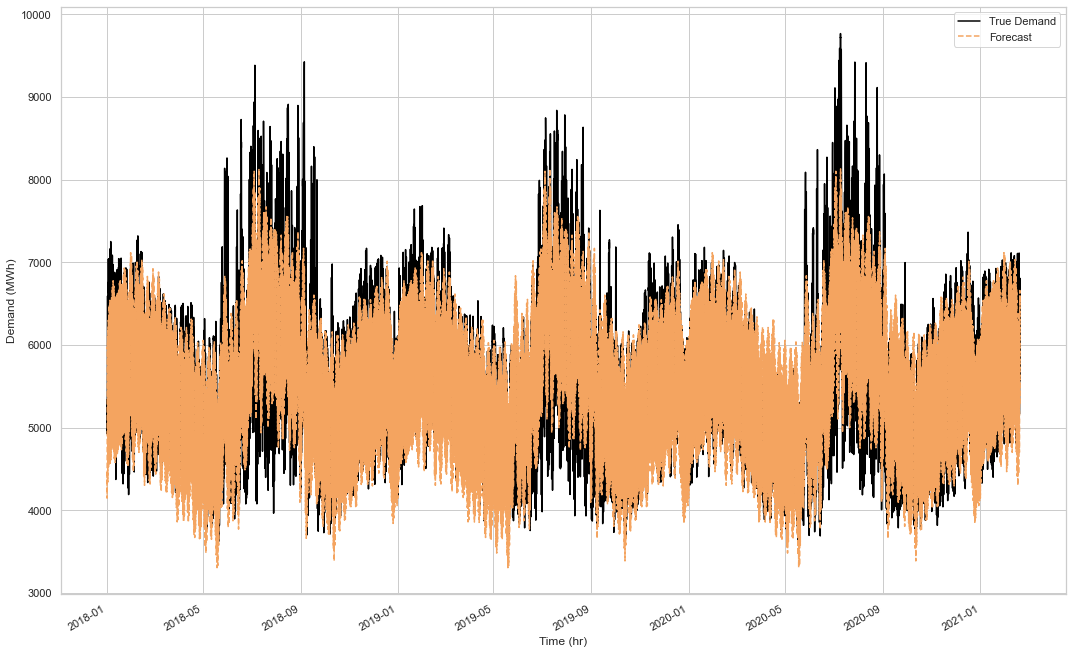

In [16]:
myterms_1 = [5,10,15,25,60,75,80,90]
myterms_2 = [5,10,15,20]

aic = np.zeros((len(myterms_1),len(myterms_2)))

for i,K1 in enumerate(myterms_1):
    for j,K2 in enumerate(myterms_2):
    
        df = fourier_terms_year_day(data,K1,K2)

        demand = df.pop('demand')
        df['demand'] = demand
        X_train, X_test, y_train, y_test = my_data(df,'2021-01-20')

        X_train = sm.add_constant(X_train)
        X_test = sm.add_constant(X_test)

        model = sm.OLS(y_train,X_train).fit()
    
        aic[i][j] = model.aic
        
K1_4 = myterms_1[math.floor(aic.argmin()/len(myterms_2))]
K2_4 = myterms_2[aic.argmin() - (math.floor(aic.argmin()/len(myterms_2)))*len(myterms_2)]

df_4 = fourier_terms_year_day(data,K1_4,K2_4)

df_4['demand'] = df_4.pop('demand')

X_train_4, X_test_4, y_train_4, y_test_4 = my_data(df_4,'2021-01-20')

X_train_4 = sm.add_constant(X_train_4)
X_test_4 = sm.add_constant(X_test_4)

model_4 = sm.OLS(y_train_4,X_train_4).fit()
predictions_4 = model_4.predict(X_test_4)

print(f'The value of K: ({K1_4,K2_4})')

plt.plot(data.reset_index()['timestamp'], data['demand'], label='True Demand',color="black");
plt.plot(model_4.predict(sm.add_constant(df_4.loc[:, df_4.columns != 'demand'])),label='Forecast',color='sandybrown',linestyle='dashed') 
plt.gcf().autofmt_xdate();
plt.legend();
plt.xlabel('Time (hr)');
plt.ylabel('Demand (MWh)');

In [17]:
data_2 = data_1.copy()
data_1['temperature'] = data_1.pop('temperature')
display(data_1.head())
display(data_1.shape)

,temp_index,week_index,demand,holiday_idx,temperature
timestamp,,,,,
2018-01-01 00:00:00,0,1,5340.0,0,-19.5
2018-01-01 01:00:00,0,1,5211.0,0,-21.7
2018-01-01 02:00:00,0,1,5096.0,0,-19.3
2018-01-01 03:00:00,0,1,4987.0,0,-20.3
2018-01-01 04:00:00,0,1,4926.0,0,-19.9


(27501, 5)

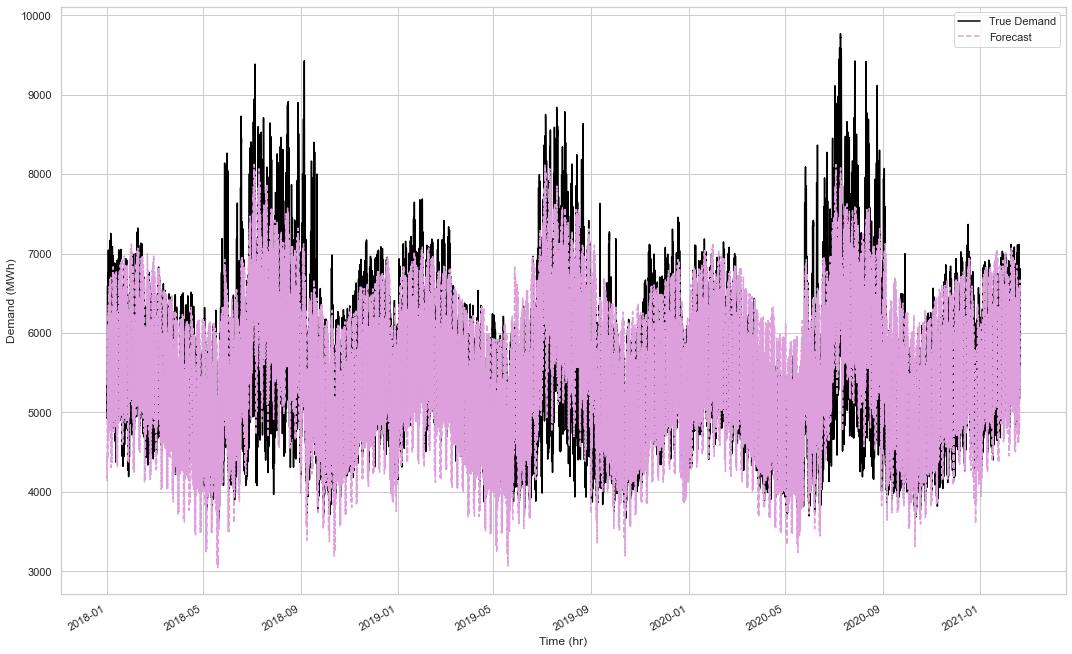

In [54]:
df_5 = fourier_terms_year_day(data_1,K1_4,K2_4)

df_5['demand'] = df_5.pop('demand')

X_train_5, X_test_5, y_train_5, y_test_5 = my_data(df_5,'2021-01-20')

X_train_5 = sm.add_constant(X_train_5)
X_test_5 = sm.add_constant(X_test_5)

model_5 = sm.OLS(y_train_5,X_train_5).fit()
predictions_5 = model_5.predict(X_test_5)

plt.plot(data.reset_index()['timestamp'], data['demand'], label='True Demand',color="black");
plt.plot(model_5.predict(sm.add_constant(df_5.loc[:, df_5.columns != 'demand'])),label='Forecast',color='plum',linestyle='dashed') 
plt.gcf().autofmt_xdate();
plt.legend();
plt.xlabel('Time (hr)');
plt.ylabel('Demand (MWh)');

In [19]:
data_3 = data_2.copy()
data_2.drop(['week_index'],axis=1,inplace=True)
display(data_2.head())
display(data_2.shape)

,temp_index,temperature,demand,holiday_idx
timestamp,,,,
2018-01-01 00:00:00,0,-19.5,5340.0,0
2018-01-01 01:00:00,0,-21.7,5211.0,0
2018-01-01 02:00:00,0,-19.3,5096.0,0
2018-01-01 03:00:00,0,-20.3,4987.0,0
2018-01-01 04:00:00,0,-19.9,4926.0,0


(27501, 4)

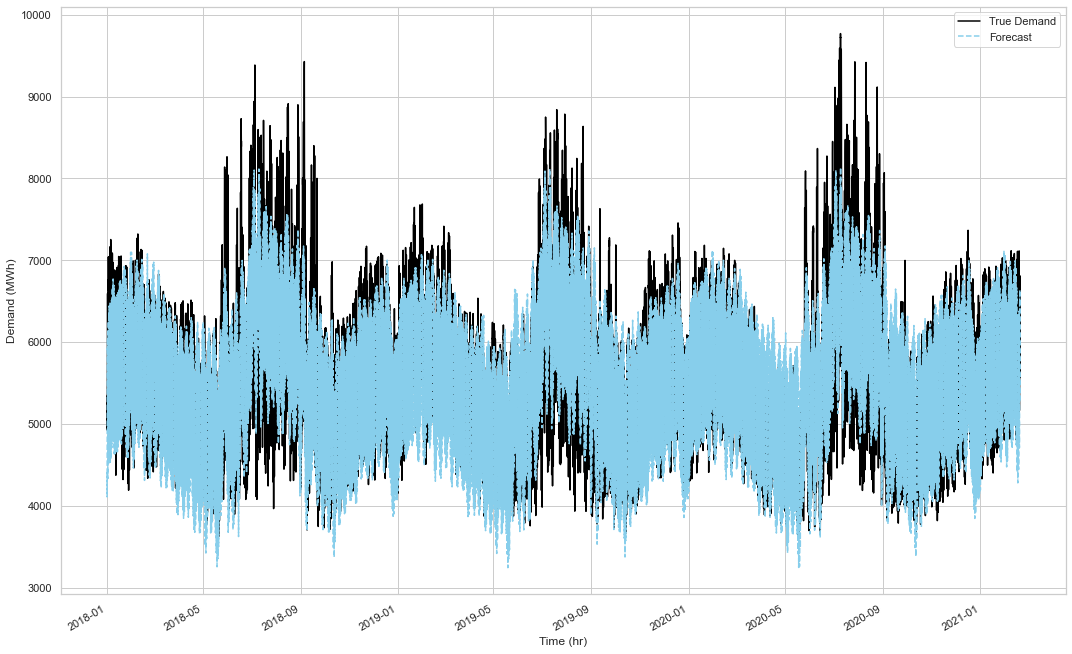

In [52]:
df_6 = fourier_terms_year_day(data_2,K1_4,K2_4)

df_6['demand'] = df_6.pop('demand')

X_train_6, X_test_6, y_train_6, y_test_6 = my_data(df_6,'2021-01-20')

X_train_6 = sm.add_constant(X_train_6)
X_test_6 = sm.add_constant(X_test_6)

model_6 = sm.OLS(y_train_6,X_train_6).fit()
predictions_6 = model_6.predict(X_test_6)

plt.plot(data.reset_index()['timestamp'], data['demand'], label='True Demand',color="black");
plt.plot(model_6.predict(sm.add_constant(df_6.loc[:, df_6.columns != 'demand'])),label='Forecast',color='skyblue',linestyle='dashed') 
plt.gcf().autofmt_xdate();
plt.legend();
plt.xlabel('Time (hr)');
plt.ylabel('Demand (MWh)');

In [56]:
data_4 = data_3.copy()
data_3.drop(['temperature'],axis=1,inplace=True)
display(data_3.head())
display(data_3.shape)

,temp_index,week_index,demand,holiday_idx
timestamp,,,,
2018-01-01 00:00:00,0,1,5340.0,0
2018-01-01 01:00:00,0,1,5211.0,0
2018-01-01 02:00:00,0,1,5096.0,0
2018-01-01 03:00:00,0,1,4987.0,0
2018-01-01 04:00:00,0,1,4926.0,0


(27501, 4)

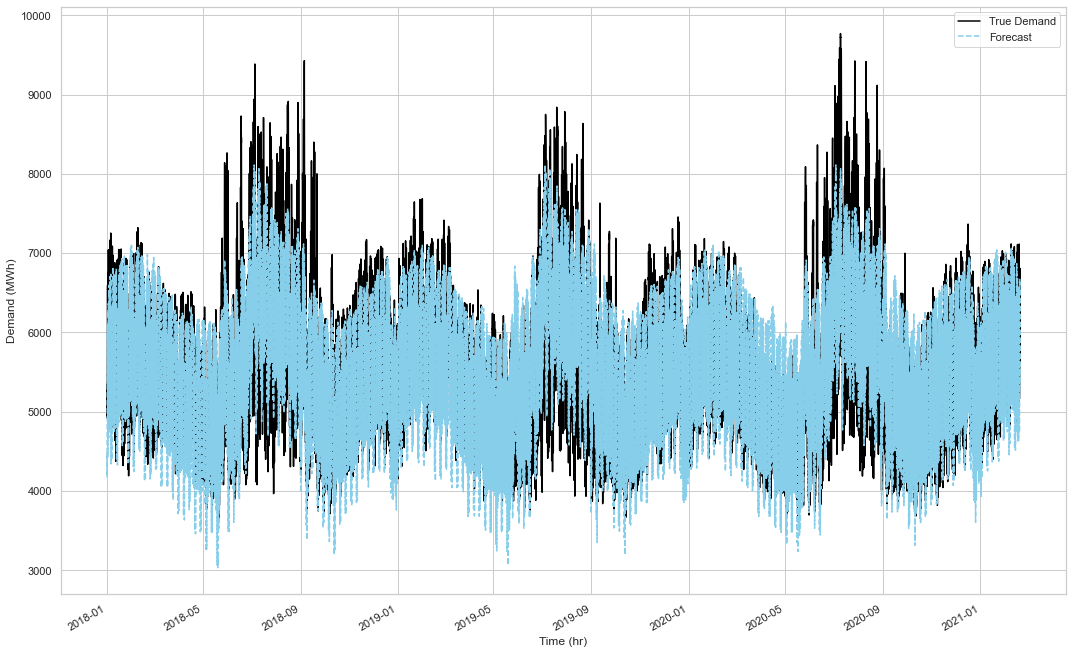

In [57]:
df_7 = fourier_terms_year_day(data_3,K1_4,K2_4)

df_7['demand'] = df_7.pop('demand')

X_train_7, X_test_7, y_train_7, y_test_7 = my_data(df_7,'2021-01-20')

X_train_7 = sm.add_constant(X_train_7)
X_test_7 = sm.add_constant(X_test_7)

model_7 = sm.OLS(y_train_7,X_train_7).fit()
predictions_7 = model_7.predict(X_test_7)

plt.plot(data.reset_index()['timestamp'], data['demand'], label='True Demand',color="black");
plt.plot(model_7.predict(sm.add_constant(df_7.loc[:, df_7.columns != 'demand'])),label='Forecast',color='skyblue',linestyle='dashed') 
plt.gcf().autofmt_xdate();
plt.legend();
plt.xlabel('Time (hr)');
plt.ylabel('Demand (MWh)');

In [63]:
data_5 = data_4.copy()
data_4.drop(['temperature','temp_index'],axis=1,inplace=True)
display(data_4.head())
display(data_4.shape)

,week_index,demand,holiday_idx
timestamp,,,
2018-01-01 00:00:00,1,5340.0,0
2018-01-01 01:00:00,1,5211.0,0
2018-01-01 02:00:00,1,5096.0,0
2018-01-01 03:00:00,1,4987.0,0
2018-01-01 04:00:00,1,4926.0,0


(27501, 3)

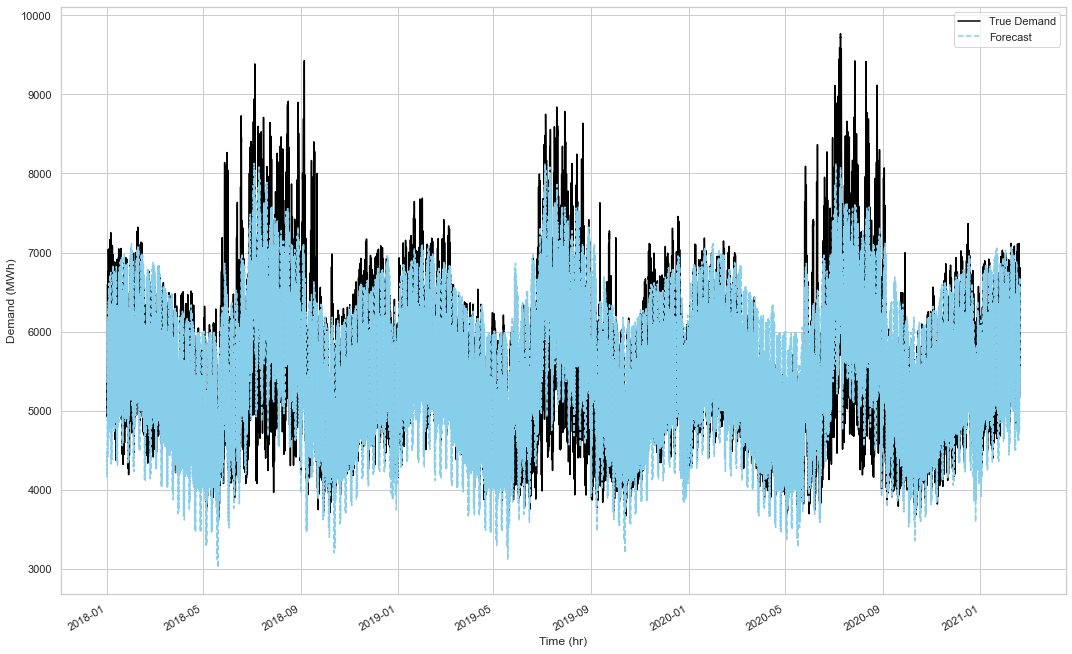

In [64]:
df_8 = fourier_terms_year_day(data_4,K1_4,K2_4)

df_8['demand'] = df_8.pop('demand')

X_train_8, X_test_8, y_train_8, y_test_8 = my_data(df_8,'2021-01-20')

X_train_8 = sm.add_constant(X_train_8)
X_test_8 = sm.add_constant(X_test_8)

model_8 = sm.OLS(y_train_8,X_train_8).fit()
predictions_8 = model_8.predict(X_test_8)

plt.plot(data.reset_index()['timestamp'], data['demand'], label='True Demand',color="black");
plt.plot(model_8.predict(sm.add_constant(df_8.loc[:, df_8.columns != 'demand'])),label='Forecast',color='skyblue',linestyle='dashed') 
plt.gcf().autofmt_xdate();
plt.legend();
plt.xlabel('Time (hr)');
plt.ylabel('Demand (MWh)');

In [69]:
data_6 = data_5.copy()
data_5.drop(['temperature','temp_index','week_index'],axis=1,inplace=True)
display(data_5.head())
display(data_5.shape)

,demand,holiday_idx
timestamp,,
2018-01-01 00:00:00,5340.0,0
2018-01-01 01:00:00,5211.0,0
2018-01-01 02:00:00,5096.0,0
2018-01-01 03:00:00,4987.0,0
2018-01-01 04:00:00,4926.0,0


(27501, 2)

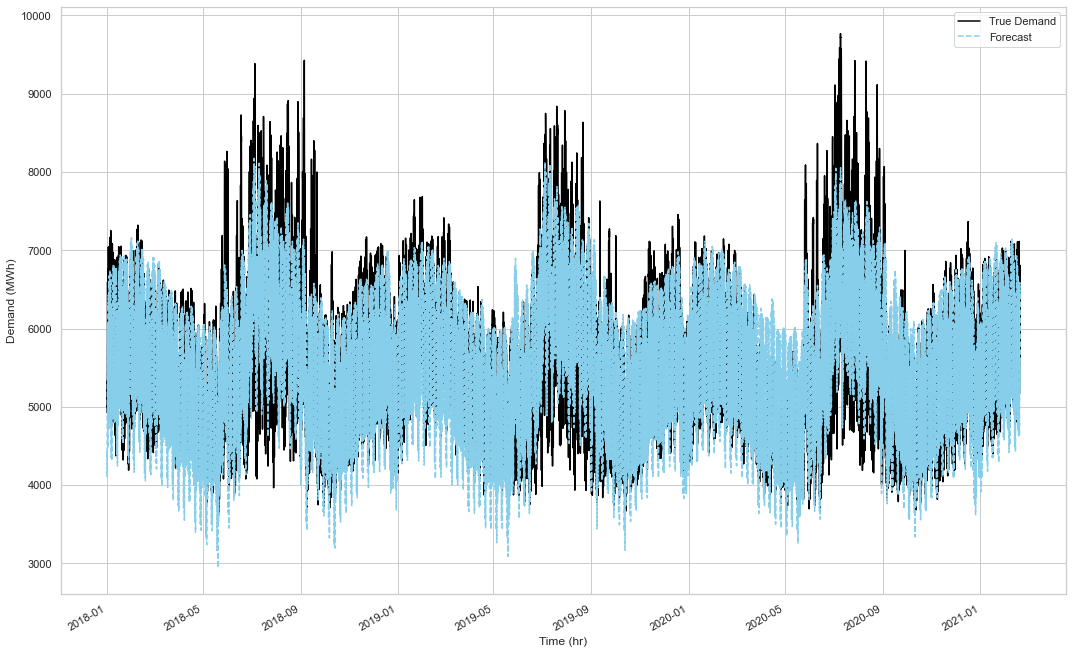

In [70]:
df_9 = fourier_terms_year_week_day(data_5,K1_3,K2_3,K3_3)

df_9['demand'] = df_9.pop('demand')

X_train_9, X_test_9, y_train_9, y_test_9 = my_data(df_9,'2021-01-20')

X_train_9 = sm.add_constant(X_train_9)
X_test_9 = sm.add_constant(X_test_9)

model_9 = sm.OLS(y_train_9,X_train_9).fit()
predictions_9 = model_9.predict(X_test_9)

plt.plot(data.reset_index()['timestamp'], data['demand'], label='True Demand',color="black");
plt.plot(model_9.predict(sm.add_constant(df_9.loc[:, df_9.columns != 'demand'])),label='Forecast',color='skyblue',linestyle='dashed') 
plt.gcf().autofmt_xdate();
plt.legend();
plt.xlabel('Time (hr)');
plt.ylabel('Demand (MWh)');

In [71]:
print(f'Model 1 AIC: {model_1.aic}')
print(f'Model 2 AIC: {model_2.aic}')
print(f'Model 3 AIC: {model_3.aic}')
print(f'Model 4 AIC: {model_4.aic}')
print(f'Model 5 AIC: {model_5.aic}')
print(f'Model 6 AIC: {model_6.aic}')
print(f'Model 7 AIC: {model_7.aic}')
print(f'Model 8 AIC: {model_8.aic}')
print(f'Model 9 AIC: {model_9.aic}')

Model 1 AIC: 437623.1123607759
Model 2 AIC: 436300.85643772036
Model 3 AIC: 403102.0702631051
Model 4 AIC: 407466.515701666
Model 5 AIC: 402979.2063366022
Model 6 AIC: 407103.9190812204
Model 7 AIC: 402986.785264414
Model 8 AIC: 403313.9907995092
Model 9 AIC: 403099.67623245023


In [73]:
MAE_1 = np.sum(np.abs(data['demand'] - model_1.predict(sm.add_constant(df_1.loc[:, df_1.columns != 'demand']))))/data.shape[0]
MAE_2 = np.sum(np.abs(data['demand'] - model_2.predict(sm.add_constant(df_2.loc[:, df_2.columns != 'demand']))))/data.shape[0]
MAE_3 = np.sum(np.abs(data['demand'] - model_3.predict(sm.add_constant(df_3.loc[:, df_3.columns != 'demand']))))/data.shape[0]
MAE_4 = np.sum(np.abs(data['demand'] - model_4.predict(sm.add_constant(df_4.loc[:, df_4.columns != 'demand']))))/data.shape[0]
MAE_5 = np.sum(np.abs(data['demand'] - model_5.predict(sm.add_constant(df_5.loc[:, df_5.columns != 'demand']))))/data.shape[0]
MAE_6 = np.sum(np.abs(data['demand'] - model_6.predict(sm.add_constant(df_6.loc[:, df_6.columns != 'demand']))))/data.shape[0]
MAE_7 = np.sum(np.abs(data['demand'] - model_7.predict(sm.add_constant(df_7.loc[:, df_7.columns != 'demand']))))/data.shape[0]
MAE_8 = np.sum(np.abs(data['demand'] - model_8.predict(sm.add_constant(df_8.loc[:, df_8.columns != 'demand']))))/data.shape[0]
MAE_9 = np.sum(np.abs(data['demand'] - model_9.predict(sm.add_constant(df_9.loc[:, df_9.columns != 'demand']))))/data.shape[0]

In [74]:
print(f'Model 1 MAE: {MAE_1}')
print(f'Model 2 MAE: {MAE_2}')
print(f'Model 3 MAE: {MAE_3}')
print(f'Model 4 MAE: {MAE_4}')
print(f'Model 5 MAE: {MAE_5}')
print(f'Model 6 MAE: {MAE_6}')
print(f'Model 7 MAE: {MAE_7}')
print(f'Model 8 MAE: {MAE_8}')
print(f'Model 9 MAE: {MAE_9}')

Model 1 MAE: 702.7552149498346
Model 2 MAE: 680.2482950629773
Model 3 MAE: 332.70699042885
Model 4 MAE: 366.3607468941646
Model 5 MAE: 333.8856569950135
Model 6 MAE: 365.82651285963215
Model 7 MAE: 332.751940097946
Model 8 MAE: 334.14192073614555
Model 9 MAE: 332.8072420128815


In [22]:
sarima_errors_5 = data.loc[:'2021-01-19']['demand'] - model_5.predict(sm.add_constant(df_5.loc[:'2021-01-19'].loc[:, df_5.columns != 'demand']))

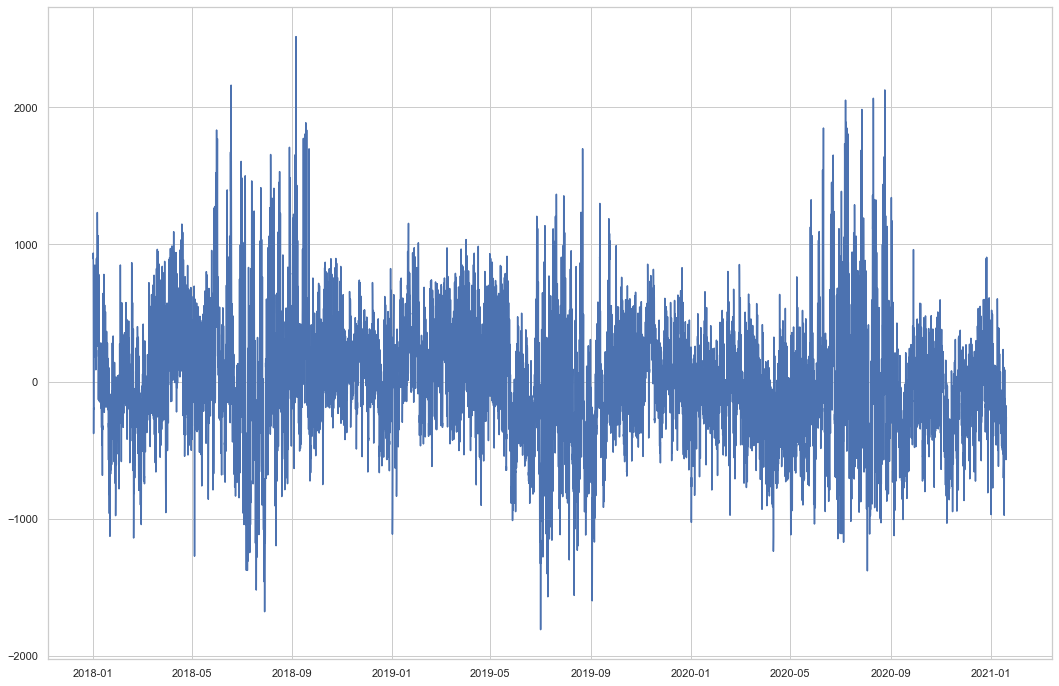

In [23]:
plt.plot(sarima_errors_5);

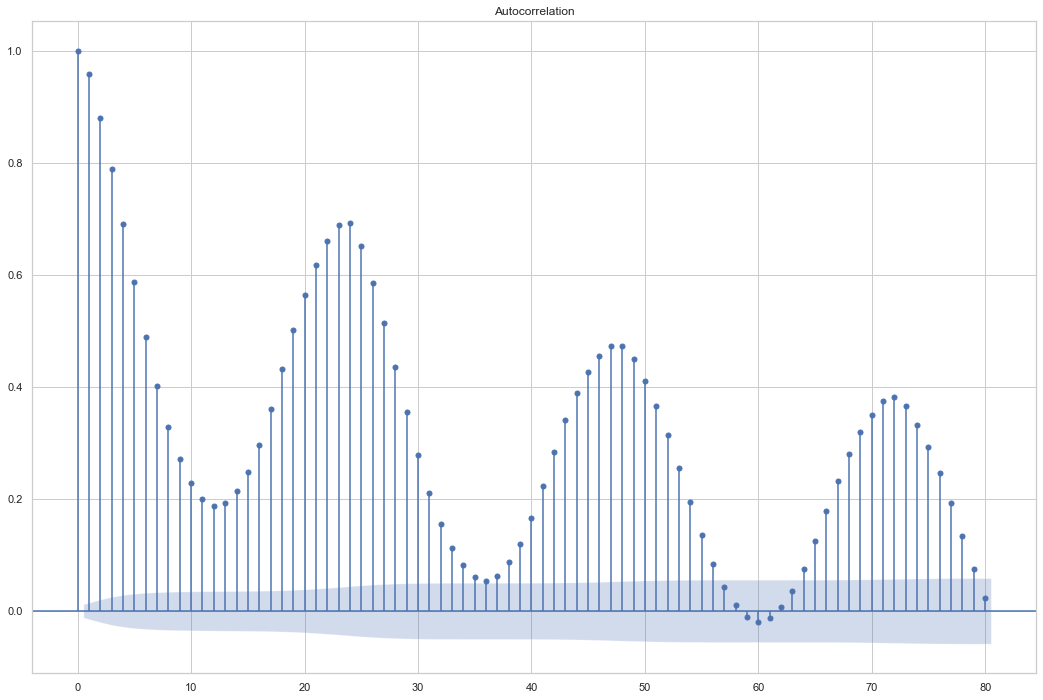

In [24]:
plot_acf(sarima_errors_5,lags=80);

In [25]:
stl = STL(sarima_errors_5,period=24)

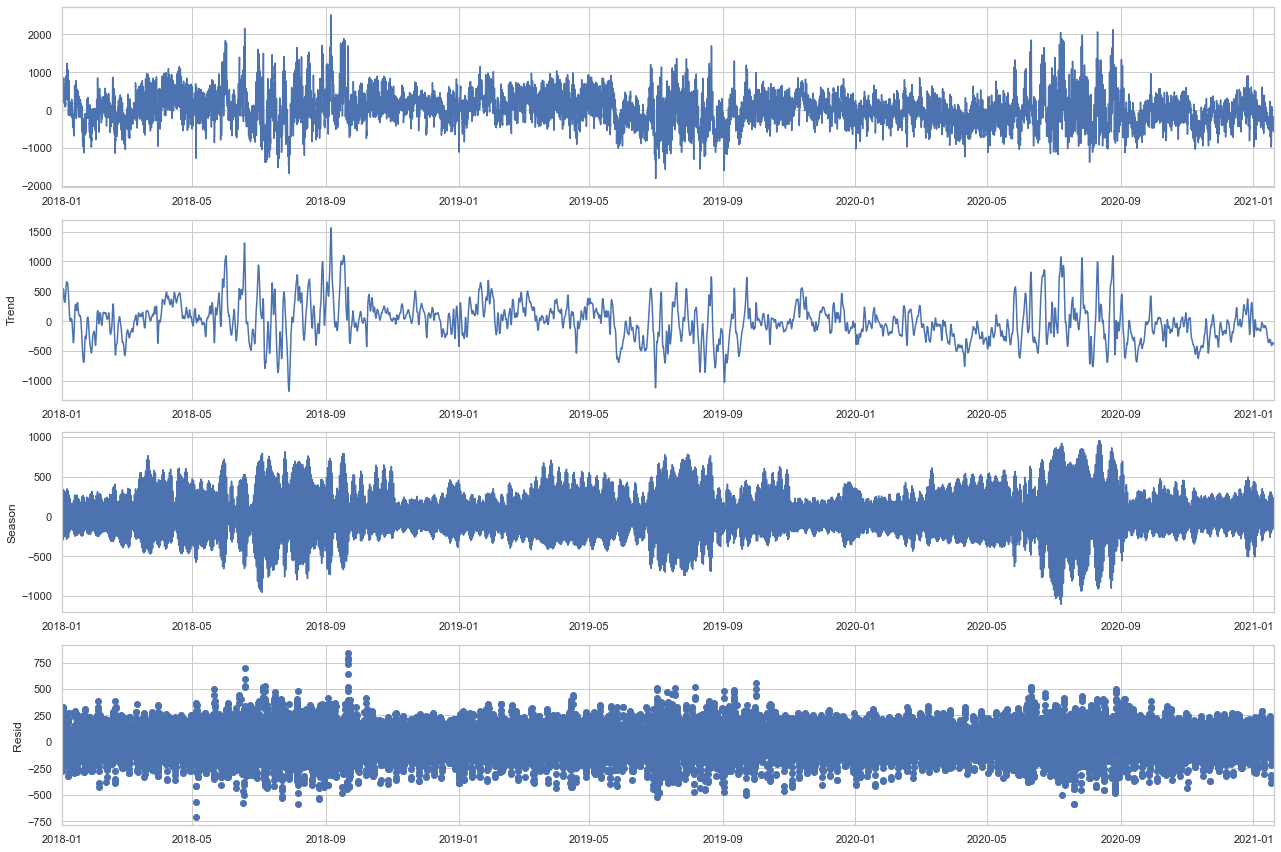

In [26]:
stl.fit().plot();

In [27]:
adf_test = pm.arima.ADFTest(alpha=0.05)
display(adf_test.should_diff(sarima_errors_5))

(0.01, False)

In [ ]:
sarima_model = pm.auto_arima(y = sarima_errors_5,
                              start_p = 0,
                              d = 1,
                              start_q = 0,
                              max_p = 2,
                              max_d = 2,
                              max_q = 2,
                              start_P = 0,
                              D = 1,
                              start_Q = 0,
                              max_P = 2,
                              max_D = 2,
                              max_Q = 2,
                              m = 24,
                              seasonal = True,
                              information_criterion = 'aic',
                              trace = True,
                              suppress_warnings = True,
                              max_iters = 10 
                             )

Performing stepwise search to minimize aic


MemoryError: Unable to allocate 138. MiB for an array with shape (26, 26, 26758) and data type float64